# **Practice: Population genomics with scikit-allel**
**MSc in Bioinformatics UAB, 2026**

In this practical, we will:

1.   learn about how to manipultate VCF files, and
2.   perform simple downstream analyses of genetic diversity

We will work with variant data for **wild and domesticated pineapple and grape**, but these approaches can be applied to any species!



---


**Installing and importing packages**

Install the scikit-allel package

In [ ]:
%pip install scikit-allel

Verify that the package was installed correctly

In [ ]:
import allel; print('scikit-allel', allel.__version__)


Import packages

In [ ]:
import random
random.seed(42)
import time
import numpy as np
np.random.seed(42)
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas
import allel



---


**About the data**

The data used in this practical is from a paper on the domestication history of the pineapple: https://www.nature.com/articles/s41588-019-0506-8

In this paper, the authors resequenced ~90 accessions of pineapple from around the world and a few dozen wild species as well. We will be replicating a few of the analyses in the paper.

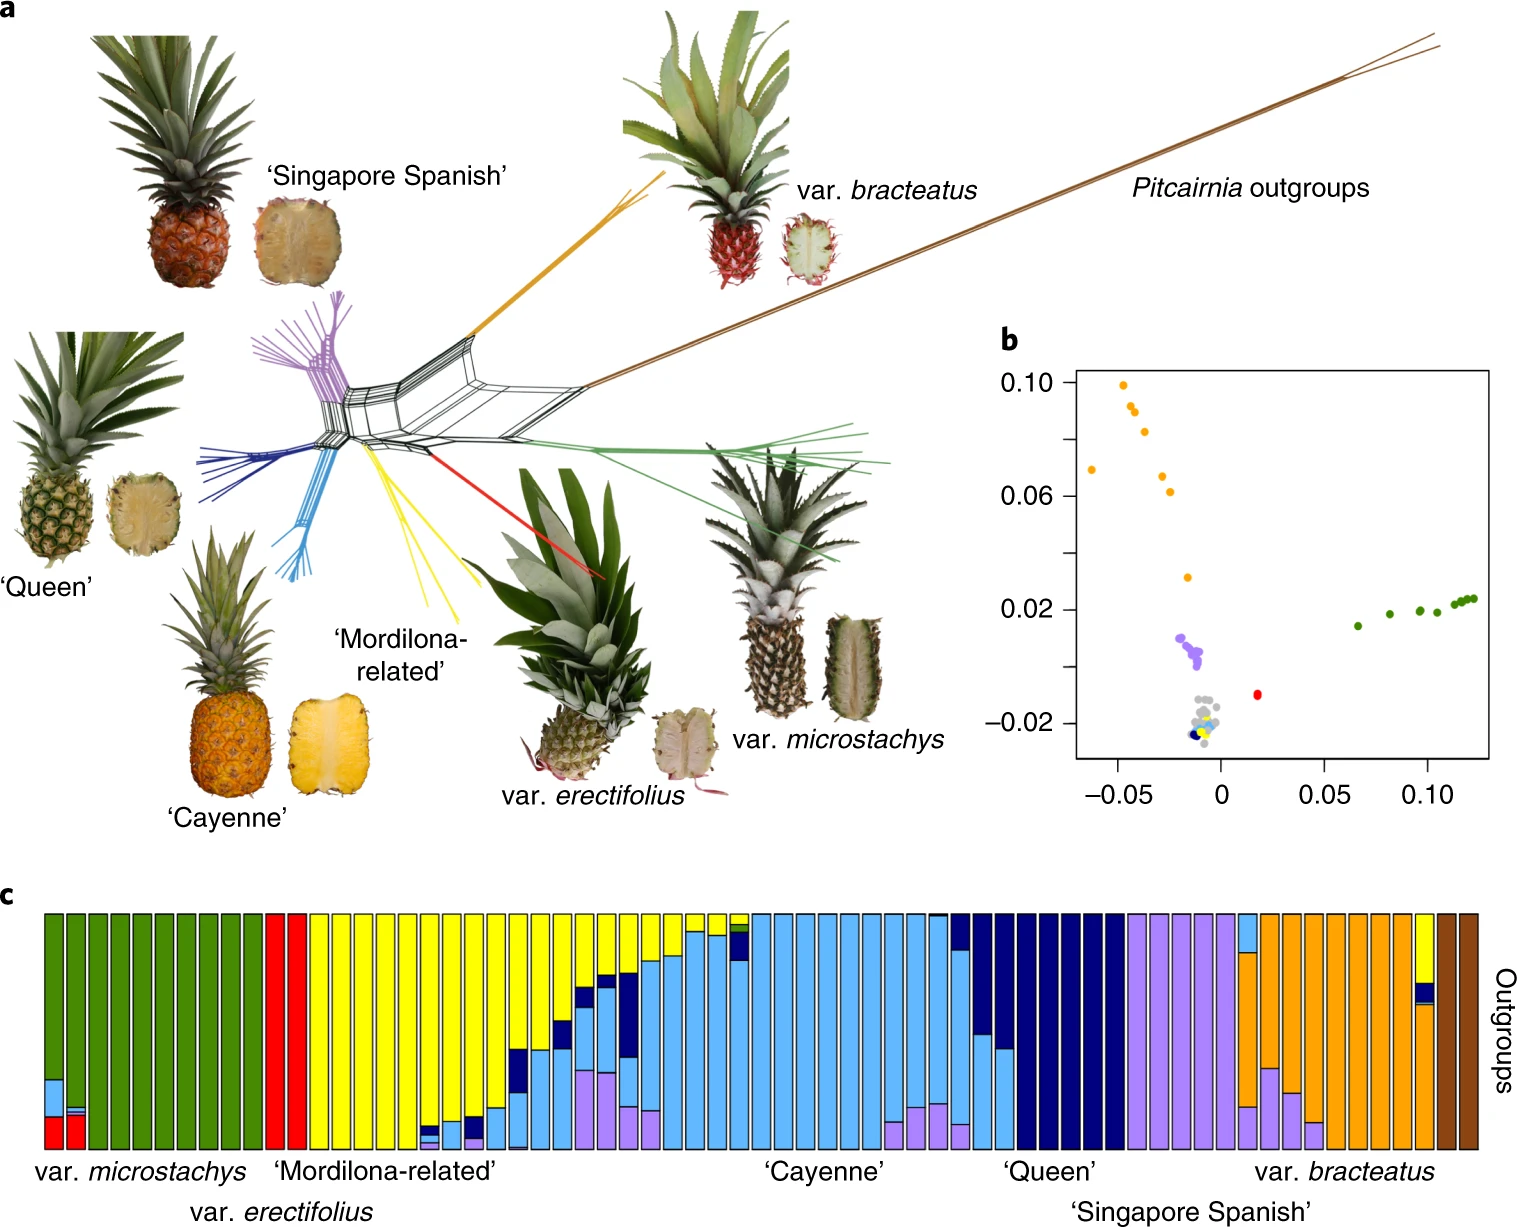

We will first import a simplified vcf file containing a subset of the variants that were used in this paper (**pineapple.vcf**). Upload the file to session storage.



---

**Reading the VCF file**

The first step is to read in the vcf file, and we'll do this using allel.read_vcf. We will use fields='*' to import all the fields:

In [ ]:
pineapple = allel.read_vcf('pineapple.vcf', fields='*')

Now lets look at the vcf file we imported:

In [ ]:
print(pineapple)

This is basically a raw NumPy array, so it’s not intuitive to read if you are a human. We can import it as a dataframe instead, so that we fellow humans can interpret it. Note: we aren’t going to do anything with this NumPy array, but you could.

Importing the vcf file as a dataframe:

In [ ]:
pineapple_df = allel.vcf_to_dataframe('pineapple.vcf', fields='*', alt_number=2)
pineapple_df

The object returned by read_vcf() is a Python dictionary with several NumPy arrays, each of which can be accessed via a key. Lets see the available keys:

In [ ]:
sorted(pineapple.keys())

As you can see, there are many keys, and you can learn more about each key in the description of vcf files above. The samples array contains sample identifiers extracted from the header line in the VCF file. We can use these later on when we plot things:

In [ ]:
pineapple['samples']

Extract the cultivar groups from the sample names (the first two characters of the sample names identify the cultivar group):

In [ ]:
samples = pineapple['samples']
species_labels = [s[:2] for s in samples]  # First two characters represent species
unique_species = list(set(species_labels))
unique_species

A0 is the reference *Ananas* sequence.

These are the **cultivar groups**:
*   Aa = Ananas comosus var. microstachys (**wild**)
*   Ab = Ananas comosus var. bracteatus (**cultivated**)
*   Ac = Ananas comosus var. comosus (**cultivated**)
*   Ae = Ananas comosus var. erectifolius (**cultivated**)

Identify which samples correspond to each species:

In [ ]:
species_indices = {species: np.array([i for i, s in enumerate(species_labels) if s == species]) for species in unique_species}
species_indices



---

**Compute genetic diversity metrics**

To compute genetic diversity metrics, we need a simple dataframe of integers (0, 1, and 2) instead of the complex numpy arrays we have after importing a vcf file. We can use the allel.GenotypeArray function to pull out only the genotype data (key ‘calldata/GT’):

In [ ]:
gt = allel.GenotypeArray(pineapple['calldata/GT'])
gt

Retrieve the positions of the variants in the VCF file:

In [ ]:
positions = pineapple['variants/POS']
positions

Retrieve the positions of the chromosomes in the VCF file:

In [ ]:
chromosomes = pineapple['variants/CHROM']
chromosomes

Calculate allele frequencies:

In [ ]:
allele_counts = gt.count_alleles()
af = allele_counts.to_frequencies()
af

Generate allele frequency distribution plots:

In [ ]:
plt.hist(af[:, 1], bins=50, alpha=0.75)
plt.xlabel('Allele Frequency')
plt.ylabel('Count')
plt.title('Allele Frequency Spectrum')
plt.show()



---

**Population stratification with PCA**

Next, we will use a principle component analysis (PCA) to describe the data. We want to investigate whether there are distinct sets of variants that are found in only domesticated or only wild pineapple, leading to a strong separation of the two groups. The wild progenitor species of pineapple should contain a subset of variants that are shared with pineapple, so we might extpect these to be closer to the cultivated accessions than the wild.

We first use the to_n_alt() function to transform each genotype call into the number of non-reference alleles. In this case, a 0/0 would be transformed into 0, 0/1 into 1, and 1/1 into 2:

In [ ]:
gn = gt.to_n_alt()
gn

Then, we can use the allel.pca function to run the principle component analysis (PCA). We need to feed it our simplified array, the number of components (set to 10), and the scaler (Patterson is based on the methods from the first paper to use PCA to survey genetic diversity):

In [ ]:
coords1, model1 = allel.pca(gn, n_components=2, scaler='patterson')

Finally, we can plot the PCA. We will use matplotlib. We will use the ‘samples’ array to label each sample, and color the dots based on the cultivar group.

In [ ]:
import matplotlib.pyplot as plt

# Assign colors based on species
colors = sns.color_palette("hsv", len(unique_species))
species_color_map = dict(zip(unique_species, colors))
species_colors = [species_color_map[sp] for sp in species_labels]

# Plot the VCA
plt.figure(figsize=(15,12))
sns.scatterplot(x=coords1[:,0], y=coords1[:,1], hue=species_labels, palette=species_color_map)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Population Structure by Species")
plt.legend(title="Species")
labels = pineapple['samples']
for label, x, y in zip(labels, coords1[:, 0], coords1[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

We can similarly group the genetic data using a Hierarchical Clustering approach. This is similar to PCA and is often congruent with a phylogenetic approach. Below, samples are broken down into wild pineapple (in green) and domesticated (red):

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(coords1, 'ward')

labelList = pineapple['samples']

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()



---

**Questions**

How many variants are there in the VCF file?

In [ ]:
gt.n_variants

How many samples?

In [ ]:
gt.n_samples

What is ploidy of the data?

In [ ]:
gt.ploidy

You can also get the values above by using:

In [ ]:
gt.shape

How many of the variables are segregating? How many of them are biallelic?

In [ ]:
ac = gt.count_alleles()
seg = ac.is_segregating()
bi = ac.is_biallelic_01()

print('Original number of variant',gt.shape)
print('Segregating variants',gt.compress(seg).shape)
print('Biallelic variants',gt.compress(bi).shape)

How do wild vs cultivated samples differ in the PCA? Is this observed in the Hierarchical Clustering approach?

Analyze, similarly, data from grapes (**grape.vcf**).

What else can you do to analyze genetic diversity and adaptation in the data, or explore genetic differences between wild and cultivated groups?

Explore the [scikit-allel documentation](https://scikit-allel.readthedocs.io/en/stable/index.html) and the [scikit-learn documentation](https://scikit-learn.org/stable/) to know about additional analyses that can be performed.

Optionally, you can upload a link to your Colab in the Moodle.



---


**Credits:** Modified from *Plants & Python*, by Robert VanBuren, Alejandra Rougon-Cardoso, Erik J. Amézquita, Evelia L. Coss-Navarrete, Aarón Espinosa-Jaime, Omar Andres Gonzalez-Iturbe, Alicia C. Luckie-Duque, Eddy Mendoza-Galindo, Jeremy Pardo, Guillermo Rodríguez-Guerrero, Pablo Y. Rosiles-Loeza, Marilyn Vásquez-Cruz, Selene L. Fernandez-Valverde, Tania Hernández-Hernández, Sourabh Palande, Daniel H. Chitwood. https://plantsandpython.github.io/PlantsAndPython/R_11_VARIANT_DISCOVERY/1_Practice.html